# Rockall Trough transport

In [1]:
import sys; sys.path.append(r'../../') # Add this line at the beginner of each notebook to be able to load local functions 
# (sys.path.inser(0,'../..') might be needed if local functions have the same name as some global functions - not good practice)
%load_ext autoreload
from src.data.make_dataset import make_OSNAP_I_section, mt2dt, IB_mat2nc,OSNAP_mat2nc
from src.visualization.visualize import make_OSNAP_I_section_plot,plot_OSNAP_I_vs_OSNAP_map
%matplotlib inline
from matplotlib import pyplot as plt
from xorca_lonlat2ij import get_ij

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist

### Set path and load data

In [3]:
# intput data
global_data_path = Path("C:/Users/sa07kb/OneDrive - SAMS/data/")

# output data
data_out_path = "C:/Users/sa07kb/Projects/OSNAPi/data/processed/timeseries/"
Path(data_out_path).mkdir(parents=True, exist_ok=True)

# output data
data_out_path_OSNAPi = "C:/Users/sa07kb/Projects/OSNAPi/data/processed/"
Path(data_out_path).mkdir(parents=True, exist_ok=True)

In [8]:
# file directories
GEBCO_data_path = (global_data_path/ 'data_GEBCO')
GLORYS_data_path = (global_data_path/ 'data_GLORYS')
RT_mooring_data_path = (global_data_path/ 'data_RT_mooring')
ERA5_data_path = (global_data_path/ 'data_ERA5/Rockall_Trough')
OSNAP_I_section_data_path = (global_data_path/ 'data_OSNAP_I')

# file names
RT_mooring_fn = 'Rockall-Trough-Mooring-Time-Series-2022.nc'
GEBCO_fn = 'GEBCO_2014_2D_-22.0_55.0_-7.0_59.0.nc'
GLORYS_fn_re = list(sorted(
        (GLORYS_data_path).glob(f"*reanalyis-phy*Vvel.nc") # reanalysis
    ))
GLORYS_fn_an = list(sorted(
        (GLORYS_data_path).glob(f"*anfc-phy-001_024_Vvel.nc") # analysis/forecasts
    ))
ERA5_fn = 'ERA5_tauxy_RT_2014-2022.nc' 

In [9]:
# input parameters
filter_length = 90;     # (days)
corr_model = 0.0759;    # Correction parameter (m/s) to adjust GLORYS DAC V component to the 8 month DAC from ADCP
z_cutoff_EW = 750;     # Depth (m) where transition from GLORYS-ADCP data to CM data at Eastern wedge
z_cutoff_WW = 250;     # Depth (m) limit of upper-left corner cutout
lon_cutoff_WW = -12.906;  # Longitude limit of upper-left corner cutout
NX_WW = 100;            # Horizontal grid size in Western wedge
NX_MB = 100;           # Horizontal grid size in Mid-basin (needed for Ekman calc.)
NX_EW = 100;            # Horizontal grid size in Eastern wedge
SA_ref = 35.34;         # Reference Absolute Salinity (g/kg), for freshwater flux calc
CT_ref = 7.07;          # Reference Conservative Temperature (C), for heat flux calc
rhoCp = 4.1e6;          # Constant: Reference density times specific heat capacity (J m^-3 C^-1)   
rho0 = 1027;            # Reference density          
Omega = 7.2921e-5;      # Earth's rotation

# Load Mooring_locations
if (OSNAP_I_section_data_path/'OSNAP_I_section_coordinates.nc').is_file():
    myfile = (OSNAP_I_section_data_path/'OSNAP_I_section_coordinates.nc')
    print(f'Load existing section file: {myfile}')
    OSNAP_I_section=xr.open_dataset(myfile)
else:
    print(f'Create section file: {myfile}')
    OSNAP_I_section = make_OSNAP_I_section(global_data_path)

lon_RTWB1 = OSNAP_I_section.sel(OSNAP_ID='RTWB1').moor_lon.values;
lat_RTWB1 = OSNAP_I_section.sel(OSNAP_ID='RTWB1').moor_lat.values;
lon_RTWB2 = OSNAP_I_section.sel(OSNAP_ID='RTWB2').moor_lon.values;
lat_RTWB2 = OSNAP_I_section.sel(OSNAP_ID='RTWB2').moor_lat.values;
lon_RTWB = (lon_RTWB1 + lon_RTWB2)/2;
lat_RTWB = (lat_RTWB1 + lat_RTWB2)/2;
lon_RTEB = OSNAP_I_section.sel(OSNAP_ID='RTEB1').moor_lon.values;
lat_RTEB = OSNAP_I_section.sel(OSNAP_ID='RTEB1').moor_lat.values;
lon_RTADCP = -9.335; 
lat_RTADCP = 57.097;
lon_RTWS = -13.0323;
lat_RTWS = lat_RTWB;
lon_RTES = -9.1929;
lat_RTES = lat_RTEB;

Load existing section file: C:\Users\sa07kb\OneDrive - SAMS\data\data_OSNAP_I\OSNAP_I_section_coordinates.nc


In [10]:
# Load RT Mooring data
ds_RT = xr.open_dataset((RT_mooring_data_path/RT_mooring_fn))
ds_RT = ds_RT.where(ds_RT.TG_EAST.isel(PRES=0).notnull().drop_vars('PRES'),drop=True)

# Get z from P
ds_RT.coords['depth'] = gsw.z_from_p(ds_RT.PRES,np.mean([lat_RTWB, lat_RTEB]));
# Create merged WB1/2 CM
ds_RT['v_RTWB'] = ds_RT.V_WEST_2.where(ds_RT.V_WEST_1.isnull())
ds_RT['v_mask'] = (ds_RT.v_RTWB.notnull()+ds_RT.V_WEST_1.notnull())
ds_RT['v_RTWB'] = (ds_RT.v_RTWB.fillna(0)+ds_RT.V_WEST_1.fillna(0)).where(ds_RT.v_mask==1)

# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((GEBCO_data_path/GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS_re = xr.open_mfdataset(GLORYS_fn_re)
ds_GLORYS_an = xr.open_mfdataset(GLORYS_fn_an)
ds_GLORYS_an.coords['latitude'] = ds_GLORYS_re.latitude # lat and lon slightly different values, i.e. manually merge
ds_GLORYS_an.coords['longitude'] = ds_GLORYS_re.longitude
ds_GLORYS_an.coords['depth'] = ds_GLORYS_re.depth
ds_GLORYS = xr.concat([ds_GLORYS_re,ds_GLORYS_an],'time')

# load ERA5
ds_ERA5 = xr.open_dataset((ERA5_data_path/ERA5_fn))
ds_ERA5 = ds_ERA5.sel(expver=1).combine_first(ds_ERA5.sel(expver=5))

In [11]:
## Correct upper layer interpolation
# mask out flawed upper values - EAST
mask_hydro1 = ds_RT.SG_EAST.where(((ds_RT.PRES<=60) & 
                     (ds_RT.TIME.sel(TIME='2018-07-4,12:00:00')<=ds_RT.TIME)&
                     (ds_RT.TIME<=ds_RT.TIME.sel(TIME='2020-10-15 12:00:00')))
                   ).isnull()

mask_hydro2 = ds_RT.SG_EAST.where(((ds_RT.PRES<=80) & 
                     (ds_RT.TIME.sel(TIME='2016-6-30 12:00:00')<=ds_RT.TIME)&
                     (ds_RT.TIME<=ds_RT.TIME.sel(TIME='2016-12-10 12:00:00')))
                   ).isnull()

mask_hydro = ((mask_hydro1*1+mask_hydro2*1)==2)
TG_EAST = ds_RT.TG_EAST.where(mask_hydro).compute()
SG_EAST = ds_RT.SG_EAST.where(mask_hydro).compute()


# extrapolate values and mask out extrapolation at bottom
SG_EAST = SG_EAST.interpolate_na(dim="PRES", method="nearest", fill_value="extrapolate")
SG_EAST = SG_EAST.where(ds_RT.SG_EAST.notnull())

TG_EAST = TG_EAST.interpolate_na(dim="PRES", method="nearest", fill_value="extrapolate")
TG_EAST = TG_EAST.where(ds_RT.TG_EAST.notnull())

# mask out flawed upper values - WEST
mask_hydroW = ds_RT.SG_WEST.where(((ds_RT.PRES<=60) & 
                     (ds_RT.TIME.sel(TIME='2018-02-21 00:00')<=ds_RT.TIME)&
                     (ds_RT.TIME<=ds_RT.TIME.sel(TIME='2020-08-26 12:00:00')))
                   ).isnull()

TG_WEST = ds_RT.TG_WEST.where(mask_hydroW).compute()
SG_WEST = ds_RT.SG_WEST.where(mask_hydroW).compute()

# extrapolate values and mask out extrapolation at bottom
SG_WEST = SG_WEST.interpolate_na(dim="PRES", method="nearest", fill_value="extrapolate")
SG_WEST = SG_WEST.where(ds_RT.SG_WEST.notnull())
TG_WEST = TG_WEST.interpolate_na(dim="PRES", method="nearest", fill_value="extrapolate")
TG_WEST = TG_WEST.where(ds_RT.TG_WEST.notnull())

# overwrite files
ds_RT['SG_EAST'] = SG_EAST
ds_RT['SG_WEST'] = SG_WEST
ds_RT['TG_WEST'] = TG_WEST
ds_RT['TG_EAST'] = TG_EAST

In [12]:
data_out_path2 = '../../data/interim/mooring/rockall_trough/'
Path(data_out_path2).mkdir(parents=True, exist_ok=True)
ds_RT.to_netcdf(f'{data_out_path2}Rockall-Trough-Mooring-Time-Series-2022_corrected_kb.nc')

In [13]:
test= ds_RT.swap_dims({'PRES':'depth'})
test['depth']=-1*test.depth
test = test.interp(depth=ds_RT.PRES.values)
ds_RT = test

### functions

In [14]:
def gsw_geo_strf_dyn_height(SA,CT,P,P_ref):
    y = xr.apply_ufunc(
        gsw.geo_strf_dyn_height,
        SA,CT,P,P_ref,
        input_core_dims=[['depth','TIME'],['depth','TIME'],['depth'],[]],
        output_core_dims=[['depth','TIME']],
        dask='parallelized')
    return y

In [15]:
# bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_lowpass(lowcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='low')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data,method='gust')
    return y

def butter_lowpass_filter(data, lowcut, fs, order=4):
    b, a = butter_lowpass(lowcut,  fs, order=order)
    y = filtfilt(b, a, data,method='gust')
    return y

def lazy_butter_bp_filter(data, lowcut, highcut, fs,dim='time_counter'):
    y = xr.apply_ufunc(
        butter_bandpass_filter,
        data, lowcut, highcut, fs,
        input_core_dims=[[dim],[],[],[]],
        output_core_dims=[[dim]],
        dask='parallelized')
    return y


def lazy_butter_lp_filter(data, lowcut, fs,dim='time_counter'):
    y = xr.apply_ufunc(
        butter_lowpass_filter,
        data, lowcut, fs,
        input_core_dims=[[dim],[],[]],
        output_core_dims=[[dim]],
        dask='parallelized')
    return y

In [16]:
def xcorr_norm(x,y,dim):
        """
        Perform Cross-Correlation on x and y
        x    : 1st signal
        y    : 2nd signal

        returns
        corr : coefficients of correlation
        """
        # First normalise the variable
        xnorm = (x - x.mean(dim)) / (x.std(dim)*len(x));
        ynorm = (y - y.mean(dim)) / (y.std(dim))

        corr = signal.correlate(xnorm, ynorm, mode="full")
        lags = signal.correlation_lags(len(xnorm), len(ynorm), mode="full")
        return corr,lags

def decorrelation(x,y,dim,doplot,precision=2):
    # %% Compute auto-correlation of a variable; determine the weighted integral scale; 
    # % compute degrees of freedom in data series
    # % Compute the integral time scale and degrees of freedom in a timeseries
    # % Emery, W. J. and R. E. Thomson, 1997: Data analysis methods in physical
    # % oceanography. Pergamon, 634 pp. (see p263,265,379-380) define the
    # % integral time scale from C(0) out to the first zero crossing. Here we
    # % define the integral time scale as twice this value.
    # % Integral time scale = 2xsum(C(tau)dt) from C(0) to first zero crossing.
    # % If the autocorrelation decays linearly then the area under this triangle
    # % is 0.5 * distance to zero crossing. So twice this integral is equal to the 
    # % time to the zero crossing.
    # % If the correlation decays fast initially but more slowly later the zero
    # % crossing suggests a longer time than the sum which is really just a
    # % weighted estimate and in this case gives less weight to a long tail with
    # % low correlation.
    # %
    # %
    # % USAGE : dcl,dof = decorrelation(x,y,dim,doplot)
    # INPUT
    # % x: xarray dataarray, is first variable and normalised prior to computing the xcorrelation: xnorm = (x - x.mean(dim)) / (x.std(dim)*len(x));
    # % y: xarray, dataarray, is second and is normalised prior to computing the xcorrelation:(y - y.mean(dim)) / (y.std(dim))
    #     for autorcorrelation x and y are the same
    #   dim: str, name of dimension along with computation should take 
    # % Diagnostic doplot = 1/0 for diagnostic plots.
    #
    # OUTPUT
    # % dcl is the decorrelation length scale in the units of x
    # % dof is the number of degrees of freedom in x. Calculated by length(x) /
    # % dcl.
    # % Stuart Cunningham, July 2017 

    C,lags = xcorr_norm(x,y,dim) # compute normalised correlation coefficient

    # find lag value of first negative crossing
    idx2 = int((len(C)+1)/2)
    if precision>0:
        idx = next(x[0] for x in enumerate(C[idx2:]) if np.round(x[1],precision) <=0)
    else:
        idx = next(x[0] for x in enumerate(C[idx2:]) if x[1] <=0)
    
    if idx>0:
        # find index of first negative&positive crossing
        Imin,Imax= idx2-idx-1,idx2+idx

        # Integrate correlation between first neg and first pos crossing. This is the decorrelation length
        dcl=np.trapz(C[Imin:Imax],lags[Imin:Imax])

        # Degrees of freedom = length of y / dcl
        dof= len(y)/ dcl
    elif idx==0:
        dcl=np.nan
        dof=len(y)

    display(f'x has {len(y)} data cycles')
    display(f'Integral time scale (days) = {dcl}')
    display(f' : Degrees of freedom = {dof}')

    if doplot:
        
        plt.plot(lags[Imin:Imax],C[Imin:Imax]*0)
        plt.plot(lags[Imin:Imax],C[Imin:Imax])
        plt.vlines([lags[Imin],lags[Imax]],-0.2,1)
        plt.xlabel('Lags');
        plt.ylabel('Normalised Correlation Coefficient');
        plt.title('Normalised auto-correlation of ynorm')

    return dcl,dof

In [17]:
def detrend_data(ds,dim):
   
    # # remove annual and semiannual harmonic
    # ds_HF = harm_fit(ds,dims=dims)
    # ds_AH = reconstr_ts(ds_HF,ds[dims].values,365,dims=dims)
    # ds_SH = reconstr_ts(ds_HF,ds[dims].values,365/2,dims=dims)
    # ds_no_cyc = ds-ds_AH-ds_SH
    
    ds = ds - ds.mean(dim)
    
    p = ds.polyfit(dim=dim, deg=1)
    fit = xr.polyval(ds[dim], p.polyfit_coefficients)


    ## SIGNIFICANCE TEST

    # calculate degrees of freedom (dof)
    _,dof = decorrelation(ds.fillna(0),ds.fillna(0),'TIME',0);


    #find T critical value
    alpha =  1-0.05/2; # two-sided t-test
    t_crit = scipy.stats.t.ppf(q=alpha,df=dof)

    yresid = ds-fit
    yresid = (yresid**2).sum(dim); # sum of the squared residuals
    ytotal = (len(ds)-1) * ds.var(dim); # n * variance

    # adjusted coefficient of determination
    rsq_y = 1 - yresid/ytotal*(len(ds)-1)/(len(ds)-2);

    # calculate t-value
    t_val = np.sqrt((rsq_y*(dof-2))/(1-rsq_y));

    # significance test, t-test, 95% interval, H_0: R=0.0
    if abs(t_crit)<abs(t_val):
        trend_significant = True
    else:
        trend_significant = False
    
    slope=(p.polyfit_coefficients.sel(degree=1).values)
    intc=(p.polyfit_coefficients.sel(degree=0).values)
    
    # print(f'Trend of {slope} is significant: {}')
    #         ds_trnd=([dim],fit),
    #         INT_dtnd=([dim],ds-fit+ds.mean(dim)),
    #         INT_trnd_signf=(trend_significant),
        
#     top_int,bot_int = regression_line_ci(0.05,
#                                          p.polyfit_coefficients.sel(degree=1).values,
#                                          p.polyfit_coefficients.sel(degree=0).values,
#                                          ds,dims)
    
    # ds_detrend = xr.Dataset(data_vars=dict(
    #         ds_orig=([dim],ds),
    #         ds_reg_slope=(p.polyfit_coefficients.sel(degree=1).values),
    #         ds_reg_intc=(p.polyfit_coefficients.sel(degree=0).values),
    #         ds_trnd=([dim],fit),
    #         INT_dtnd=([dim],ds-fit+ds.mean(dim)),
    #         INT_trnd_signf=(trend_significant),
    #     ),
    #     coords=dict(TIME=ds[dim].values),
    #     )

    return fit, slope, intc, trend_significant

In [18]:
## Standard error
def std_error(da,dim='TIME'):
    da_std  = da.std()
    _,dof = decorrelation(da.fillna(0),da.fillna(0),dim,0);
    return da_std/np.sqrt(dof);

In [19]:
def make_attr(reg_short,reg_long,end_points,data_used,CT_ref,SA_ref,rho_ref=1027.4):
    attrs_Q = {'name':f'Q_{reg_short}',
                   'long_name':f'{reg_short} Volume Transport',
                    'units':'Sv',
                    'Description':f'{reg_long} volume transport'\
                    f' derived from dynamic height difference between {end_points}'\
                    f' using hydrography from moorings and EN4 and satellite-derive adt'
                  }
    attrs_Qh = {'name': f'Qh_{reg_short}',
                'long_name': f'{reg_short} Heat Flux',
                'units':'PW',
                'Description':f'Heat flux {reg_long}'\
                    f' derived from dynamic height difference between {end_points}'\
                    f' using hydrography from moorings and EN4 and satellite-derive adt'
                   }

    attrs_Qf = {'name': f'Qf_{reg_short}',
                'long_name': f'{reg_short} Freshwater flux',
                'units':'PW',
                'Description':f'Freshwater flux {reg_long}'\
                    f' derived from dynamic height difference between {end_points}'\
                    f' using hydrography from moorings and EN4 and satellite-derive adt'
                }

    attrs_QS = {'name': f'QS_{reg_short}',
                'long_name': f'{reg_short} salt flux',
                'units':'PW',
                'Description':f'salt flux {reg_long}'\
                    f' derived from dynamic height difference between {end_points}'\
                    f' using hydrography from moorings and EN4 and satellite-derive adt'}

    attrs_q = {'name':f'q_{reg_short}',
                   'long_name':f'{reg_short} Volume Transport per cell',
                    'units':'Sv',
                    'Description':f'Volume transport per cell {reg_long}'\
                    f' derived from dynamic height difference between {end_points}'\
                    f' using hydrography from moorings and EN4 and satellite-derive adt'\
                  }
    attrs_qh = {'name': f'qh_{reg_short}',
                'long_name': f'{reg_short} Heat Flux per cell',
                'units':'PW',
                'Description':f'Heat flux per cell {reg_long}'\
                    f' derived from dynamic height difference between {end_points}'\
                    f' using hydrography from moorings and EN4 and satellite-derive adt'\
                f' Reference temperature {CT_ref}degC',}


    attrs_qf = {'name': f'qf_{reg_short}',
                'long_name': f'{reg_short} Freshwater flux per cell',
                'units':'Sv',
                'Description':f'Freshwater flux per cell {reg_long}'\
                    f' derived from dynamic height difference between {end_points}'\
                    f' using hydrography from moorings and EN4 and satellite-derive adt'\
                f' Reference absolute salinity {SA_ref} (g/kg)',
                }

    attrs_qS = {'name': f'qS_{reg_short}',
                'long_name': f'{reg_short} salt flux per cell',
                'units':'Sv',
                'Description':f'salt flux per cell {reg_long}'\
                    f' derived from dynamic height difference between {end_points}'\
                    f' using hydrography from moorings and EN4 and satellite-derive adt'\
                f' Reference density {rho_ref} (kg/m^3)',}
    return attrs_Q,attrs_Qh,attrs_Qf,attrs_QS,attrs_q,attrs_qh,attrs_qf,attrs_qS

In [20]:
def unique_lat_lons(ds,lon_name,lat_name,dim):
    lon = ds[lon_name]
    lat = ds[lat_name]

    (dist,_) = sw.dist(lat,lon,'km')
    dist = np.append(dist,1)
    mask =  xr.DataArray((dist!=0), dims=[dim])
    ds = ds.where(mask,drop=True)
    dist = ds[lon_name].diff(dim)
    dist = np.append(1,dist)
    mask =  xr.DataArray((dist!=0), dims=[dim])
    ds = ds.where(mask,drop=True)
    return ds

In [21]:
# Get dx
def get_dx(lon,lat,dim='lon'):
    
    dx = xr.apply_ufunc(
            gsw.distance,
            lon,lat,
            input_core_dims=[[dim],[dim]],
            output_core_dims=[[dim]],
            exclude_dims=set((dim,)), 
    )
    dx1 = xr.concat([dx.shift({dim:1},fill_value=0),dx[-1]],dim=dim)
    dx2 = xr.concat([dx[0],dx.shift({dim:-1},fill_value=0)],dim=dim)
    return (dx1+dx2)/2

def get_dz(z):
    z1 = (z[0]-(z[:2].diff('depth')/2))
    if z1<0:
        dz1 = z.shift(depth=1,fill_value=0)
    else:
        dz1 = z.shift(depth=1,fill_value=(z[0]-(z[:2].diff('depth'))))
    dz2 = z.shift(depth=-1,fill_value=z[-1])
    return (dz2-dz1)/2

In [22]:
def calc_SA_CT_sigma0(ds):
    
    ds = ds.rename({'TIME':'time',
                            'LATITUDE':'lat',
                            'LONGITUDE':'lon',
                            'DEPTH':'depth',
                            'VELO':'vel',
                            'TEMP':'temp',
                            'SAL':'psal'})
    ds['lat']=('lon',ds.lat.values)
    dt='12hr'
    ds['time']=ds.time - pd.Timedelta(dt)
    CT_attrs = {'long_name':'Conservative temperature',
              'description':'conservative temperature TEOS-10',
              'units':'degC'}
    SA_attrs = {'long_name':'Absolute salinity',
            'description':'Absolute salinity TEOS-10',
             'units':'g/kg'}
    sigma0_attrs = {'long_name':'Potential density referenced to 0dbar',
                   'description':'Potential density TEOS-10', 
                 'units':'kg/m^3'}
    # calculate pressure
    ds['PRES'] = xr.apply_ufunc(
        sw.eos80.pres,
        -abs(ds.psal.depth),ds.lat,
        dask='parallelized', output_dtypes=[float, ]
        )


    ds['SA'] = xr.apply_ufunc(gsw.SA_from_SP,
                  ds.psal,ds.PRES,ds.lon,ds.lat,
                  dask = 'parallelized',output_dtypes=[float,])
    ds.SA.attrs = SA_attrs


    ds['CT'] = xr.apply_ufunc(gsw.CT_from_t,
                  ds.SA,ds.temp,ds.PRES,
                  dask = 'parallelized',output_dtypes=[float,])
    ds.CT.attrs = CT_attrs

    ds['sigma0'] = xr.apply_ufunc(gsw.sigma0,
                  ds.SA,ds.CT,
                  dask = 'parallelized',output_dtypes=[float,])
    ds.sigma0.attrs = sigma0_attrs
    return ds

### calculations

In [23]:
#First get horizontal grid
lon_WW = xr.DataArray(np.linspace(lon_RTWS,lon_RTWB,NX_WW),dims='lon_WW')
lon_MB = xr.DataArray(np.linspace(lon_RTWB,lon_RTEB,NX_MB),dims='lon_MB')
lon_EW = xr.DataArray(np.linspace(lon_RTEB,lon_RTES,NX_EW),dims='lon_EW')
lat_WW = xr.DataArray(np.linspace(lat_RTWS,lat_RTWB,NX_WW),dims='lon_WW')
lat_MB = xr.DataArray(np.linspace(lat_RTWB,lat_RTEB,NX_MB),dims='lon_MB')
lat_EW = xr.DataArray(np.linspace(lat_RTEB,lat_RTES,NX_EW),dims='lon_EW')

lon_WW.coords['lon_WW']=lon_WW.values
lat_WW.coords['lon_WW']=lon_WW.values

lon_MB.coords['lon_MB']=lon_MB.values
lat_MB.coords['lon_MB']=lon_MB.values

lon_EW.coords['lon_EW']=lon_EW.values
lat_EW.coords['lon_EW']=lon_EW.values

In [24]:
#Get dx
dx_EW = get_dx(lon_EW,lat_EW,dim='lon_EW')
dx_WW = get_dx(lon_WW,lat_WW,dim='lon_WW')

In [25]:
# Get x
x_WW = np.linspace(0,(NX_WW-1)*dx_WW,NX_WW).squeeze()
x_EW = np.linspace(0,(NX_EW-1)*dx_EW,NX_EW).squeeze()

In [26]:
# Get dz (top/bottom cells are ~10m thick, cells are ~20m thick elsewhere)
# dz = np.abs(np.diff(np.concatenate((np.expand_dims(ds_RT.depth[0].values,axis=0),
#           ((ds_RT.depth[:-1].values + ds_RT.depth[1:].values)/2).squeeze(),
#           np.expand_dims(ds_RT.depth[-1].values,axis=0)))))
dz = get_dz(ds_RT.depth)
ds_RT['dz']=xr.DataArray(dz,dims='depth')

In [27]:
# Get section bathy
bathy_WW = ds_GEBCO.elevation.interp(lon=lon_WW, lat=lat_WW).drop(['lon','lat'])
bathy_WW.coords['lon_WW']=lon_WW
bathy_EW = ds_GEBCO.elevation.interp(lon=lon_EW, lat=lat_EW).drop(['lon','lat'])
bathy_EW.coords['lon_EW']=lon_EW

In [28]:
# Midbasin transport based on no motion at 1760 dbar

# Get Coriolis freq
f = gsw.f(np.mean([lat_RTWB,lat_RTEB]))

In [29]:
P_ref = ds_RT.where((ds_RT.SG_WEST+ds_RT.SG_EAST).notnull(),drop=True).PRES.max().values

In [30]:
# create MB matrix
RT_SG_MB = xr.concat([ds_RT.SG_WEST.expand_dims('lon_MB'),
          ds_RT.SG_EAST.expand_dims('lon_MB')],dim='lon_MB')
RT_SG_MB['lon_MB']=[lon_RTWB,lon_RTEB]
RT_SG_MB.coords['lat_MB']= ('lon_MB',[lat_RTWB,lat_RTEB])

RT_TG_MB = xr.concat([ds_RT.TG_WEST.expand_dims('lon_MB'),
          ds_RT.TG_EAST.expand_dims('lon_MB')],dim='lon_MB')
RT_TG_MB['lon_MB']=[lon_RTWB,lon_RTEB]
RT_TG_MB.coords['lat_MB']= ('lon_MB',[lat_RTWB,lat_RTEB])

RT_SG_MB = RT_SG_MB.interp(lon_MB=lon_MB)
RT_TG_MB = RT_TG_MB.interp(lon_MB=lon_MB)


In [31]:
# Calculate baroclinic streamfunction
SF_MB = xr.apply_ufunc(
        gsw.geo_strf_dyn_height,
        RT_SG_MB,RT_TG_MB,RT_TG_MB.PRES,P_ref,
        kwargs={'axis':2},
        input_core_dims=[['lon_MB', 'TIME', 'depth'],['lon_MB', 'TIME', 'depth'],['depth'],[]],
        output_core_dims=[['lon_MB', 'TIME', 'depth']],
        dask = 'parallelized')

# Calculate geostrophic transport (Sv) in each cell as function of (z,t)
q_RTMB = dz*(SF_MB.diff('lon_MB')/f);

In [32]:
q_RTMB['lon_MB']=((SF_MB.lon_MB[:-1].values+SF_MB.lon_MB[1:].values)/2)

In [33]:
ds_q_RTMB = xr.merge([q_RTMB.rename('q'),
                      RT_TG_MB.rename('CT').drop('lat_MB').interp(lon_MB=q_RTMB.lon_MB),
                      RT_SG_MB.rename('SA').drop('lat_MB').interp(lon_MB=q_RTMB.lon_MB)])
dx_MB = get_dx(ds_q_RTMB.lon_MB,ds_q_RTMB.lat_MB,dim='lon_MB')
ds_q_RTMB.coords['dx']=dx_MB
x_MB = np.linspace(0,(NX_MB-1)*ds_q_RTMB.dx,NX_MB).squeeze()
ds_q_RTMB.coords['dz'] = dz
ds_q_RTMB

<xarray.Dataset>
Dimensions:  (depth: 101, TIME: 5827, lon_MB: 99)
Coordinates:
    PRES     (depth) float64 0.0 20.19 40.38 60.57 ... 1.988e+03 nan nan
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * TIME     (TIME) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    lat_MB   (lon_MB) float64 57.47 57.46 57.46 57.46 ... 57.11 57.11 57.1 57.1
  * lon_MB   (lon_MB) float64 -12.49 -12.46 -12.43 ... -9.638 -9.609 -9.579
    dx       (lon_MB) float64 913.2 1.826e+03 1.827e+03 ... 1.843e+03 921.7
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (depth, lon_MB, TIME) float64 826.5 827.8 840.9 ... nan nan nan
    CT       (lon_MB, TIME, depth) float64 10.22 10.22 10.22 ... nan nan nan
    SA       (lon_MB, TIME, depth) float64 35.56 35.56 35.56 ... nan nan nan

In [34]:
# # Calculate baroclinic streamfunction
SF_RTWB = gsw_geo_strf_dyn_height(ds_RT.SG_WEST,ds_RT.TG_WEST,ds_RT.PRES,P_ref);
SF_RTEB = gsw_geo_strf_dyn_height(ds_RT.SG_EAST,ds_RT.TG_EAST,ds_RT.PRES,P_ref);

# Calculate geostrophic transport (Sv) in each cell as function of (z,t)
q_MB = ds_RT.dz*((SF_RTEB - SF_RTWB)/f);
q_MB.coords['lat_MB']=np.mean([lat_RTWB,lat_RTEB])
q_MB.coords['lon_MB']=np.mean([lon_RTWB,lon_RTEB])

# Perform vertical integral for timeseries (Sv)
Q_MB = q_RTMB.sum(['depth','lon_MB'],min_count=1)/1e6

Q_MB.attrs['name']= 'RT_Q_MB'
Q_MB.attrs['long_name']= 'RT MB Volume Transport'
Q_MB.attrs['units']='Sv'
Q_MB.attrs['Description']='Mid basin volume transport in Rockall Trough'\
' derived from dynamic height difference between the moorings RTEB1 and RTWB1+2'

## Some sensitivity analysis - extra

# Calculate temporal mean over entire timeseries and broadcast over TIME dimension
(ds_RT_ave,_) = xr.broadcast(ds_RT.mean('TIME'),ds_RT.TIME)

# % Do it again isolating CT changes/ keeping SA fixed
SF_RTWB_SAfix = gsw_geo_strf_dyn_height(ds_RT.SG_WEST,ds_RT_ave.TG_WEST,ds_RT.PRES,P_ref);
SF_RTEB_SAfix = gsw_geo_strf_dyn_height(ds_RT.SG_EAST,ds_RT_ave.TG_EAST,ds_RT.PRES,P_ref);
q_MB_SAfix = ds_RT.dz*((SF_RTEB_SAfix - SF_RTWB_SAfix)/f);
Q_MB_SAfix = q_MB_SAfix.sum('depth',min_count=1)/1e6
Q_MB_SAfix.attrs['name']= 'RT_Q_MB_SAfix'
Q_MB_SAfix.attrs['long_name']= 'RT MB Volume Transport SA fixed'
Q_MB_SAfix.attrs['units']='Sv'
Q_MB_SAfix.attrs['Description']='As Q_MB but holding salinity fixed at temporal mean at all moorings'

# % Do it again isolating SA changes / keeping CT fixed
SF_RTWB_CTfix = gsw_geo_strf_dyn_height(ds_RT_ave.SG_WEST,ds_RT.TG_WEST,ds_RT.PRES,P_ref);
SF_RTEB_CTfix = gsw_geo_strf_dyn_height(ds_RT_ave.SG_EAST,ds_RT.TG_EAST,ds_RT.PRES,P_ref);
q_MB_CTfix = ds_RT.dz*((SF_RTEB_CTfix - SF_RTWB_CTfix)/f);
Q_MB_CTfix = q_MB_CTfix.sum('depth',min_count=1)/1e6
Q_MB_CTfix.attrs['name']= 'RT_Q_MB_CTfix'
Q_MB_CTfix.attrs['long_name']= 'RT MB Volume Transport CT fixed'
Q_MB_CTfix.attrs['units']='Sv'
Q_MB_CTfix.attrs['Description']= 'As Q_MB but holding temperature fixed at temporal mean at all moorings'

# % Do it again holding both fixed
SF_RTWB_SAfix_CTfix = gsw_geo_strf_dyn_height(ds_RT_ave.SG_WEST,ds_RT_ave.TG_WEST,ds_RT.PRES,P_ref);
SF_RTEB_SAfix_CTfix = gsw_geo_strf_dyn_height(ds_RT_ave.SG_EAST,ds_RT_ave.TG_EAST,ds_RT.PRES,P_ref);
q_MB_SAfix_CTfix = ds_RT.dz*((SF_RTEB_SAfix_CTfix - SF_RTWB_SAfix_CTfix)/f);
Q_MB_SAfix_CTfix = q_MB_SAfix_CTfix.sum('depth',min_count=1)/1e6
Q_MB_SAfix_CTfix.attrs['name']= 'RT_Q_MB_SAfix_CTfix'
Q_MB_SAfix_CTfix.attrs['long_name']= 'RT MB Volume Transport SA and CT fixed'
Q_MB_SAfix_CTfix.attrs['units']='Sv'
Q_MB_SAfix_CTfix.attrs['Description']= 'As Q_MB but holding temperature and salinity fixed at temporal mean at all moorings'

# % Do it again isolating CT_RTWB
# q4_MB = repmat(dz,[1,NT]).*(SFb_RTEB - SFt_RTWB)/f;
q_MB_WB_CTvar = ds_RT.dz*((SF_RTEB_SAfix_CTfix - SF_RTWB_SAfix)/f);
Q_MB_WB_CTvar = q_MB_WB_CTvar.sum('depth',min_count=1)/1e6
Q_MB_WB_CTvar.attrs['name']= 'RT_Q_MB_WB_CTvar'
Q_MB_WB_CTvar.attrs['long_name']= 'RT MB Volume Transport isolating CT changes at RTWB'
Q_MB_WB_CTvar.attrs['units']='Sv'
Q_MB_WB_CTvar.attrs['Description']= 'As Q_MB but isolating temperature changes at RTWB'\
                        ' and holding temperature at RTEB and salinity at RTWB & RTEB'\
                        ' fixed at temporal mean'

# % Do it again isolating CT_RTEB
q_MB_EB_CTvar = ds_RT.dz*((SF_RTEB_SAfix - SF_RTWB_SAfix_CTfix)/f);
Q_MB_EB_CTvar = q_MB_EB_CTvar.sum('depth',min_count=1)/1e6
Q_MB_EB_CTvar.attrs['name']= 'RT_Q_MB_EB_CTvar'
Q_MB_EB_CTvar.attrs['long_name']= 'RT MB Volume Transport isolating CT changes at RTEB'
Q_MB_EB_CTvar.attrs['units']='Sv'
Q_MB_EB_CTvar.attrs['Description']= 'As Q_MB but isolating temperature changes at RTEB'\
                    ' and holding temperature at RTWB and salinity at RTWB & RTEB'\
                    ' fixed at temporal mean'

# Merge to dataset
RT_Q_MB = xr.merge([Q_MB.rename(Q_MB.attrs['name']),
                Q_MB_SAfix.rename(Q_MB_SAfix.attrs['name']),
                Q_MB_CTfix.rename(Q_MB_CTfix.attrs['name']),
                Q_MB_SAfix_CTfix.rename(Q_MB_SAfix_CTfix.attrs['name']),
                Q_MB_WB_CTvar.rename(Q_MB_WB_CTvar.attrs['name']),
                Q_MB_EB_CTvar.rename(Q_MB_EB_CTvar.attrs['name'])])
RT_Q_MB

<xarray.Dataset>
Dimensions:              (TIME: 5827)
Coordinates:
  * TIME                 (TIME) datetime64[ns] 2014-07-21T12:00:00 ... 2022-0...
Data variables:
    RT_Q_MB              (TIME) float64 7.443 7.647 7.759 ... 2.396 2.155 1.858
    RT_Q_MB_SAfix        (TIME) float64 6.215 6.021 5.886 ... 5.298 5.412 5.539
    RT_Q_MB_CTfix        (TIME) float64 6.207 6.605 6.851 ... 2.08 1.725 1.301
    RT_Q_MB_SAfix_CTfix  (TIME) float64 4.98 4.98 4.98 4.98 ... 4.98 4.98 4.98
    RT_Q_MB_WB_CTvar     (TIME) float64 7.634 7.612 7.711 ... 5.103 5.053 5.102
    RT_Q_MB_EB_CTvar     (TIME) float64 3.562 3.39 3.156 ... 5.175 5.339 5.417
Attributes:
    name:         RT_Q_MB
    long_name:    RT MB Volume Transport
    units:        Sv
    Description:  Mid basin volume transport in Rockall Trough derived from d...

In [35]:
# # Western wedge transport

# Constant value east of WB1
v_WW = ds_RT.v_RTWB.rename('v_WW').compute()
(v_WW,_) = xr.broadcast(v_WW,xr.DataArray(lon_WW, dims="lon_WW"))
v_WW.coords['lon_WW']=lon_WW
v_WW.coords['lat_WW']=lat_WW
v_WW = v_WW.where(lon_WW>=lon_RTWB1)

# Upper 250 m: Linear decay from WB1 value to 0, western limit is cut off lon
i_bathy = (lon_WW<lon_RTWB1) & (lon_WW>=lon_cutoff_WW)
y = xr.apply_ufunc(
    np.linspace,
    0,ds_RT.v_RTWB.where((ds_RT.depth<z_cutoff_WW)),sum(i_bathy),
    input_core_dims=[[],['depth','TIME'],[]],
    output_core_dims=[['lon_WW','depth','TIME']],
    dask='parallelized')

y.coords['lon_WW']= lon_WW[(lon_WW<lon_RTWB1) & (lon_WW>=lon_cutoff_WW)]

(v_WW,y)=xr.broadcast(v_WW,y)
mask = (v_WW.notnull()+y.notnull())
v_WW = (v_WW.fillna(0)+y.fillna(0)).where(mask)

# Below 250 m: Linear decay from WB1 value to 0, western limit is bathymetry
i_bathy =(-1*bathy_WW.where(lon_WW<lon_RTWB1)>ds_RT.depth.where(ds_RT.depth>z_cutoff_WW))

for idx,bathy in enumerate(i_bathy.sum('lon_WW')):
    if bathy>0:
        y1 = xr.apply_ufunc(
        np.linspace,
        0,ds_RT.v_RTWB.isel(depth=[idx]),bathy,
        input_core_dims=[[],['TIME','depth'],[]],
        output_core_dims=[['lon_WW','TIME','depth']], 
        dask='parallelized')
        
        y1.coords['lon_WW']= lon_WW.values[i_bathy[:,idx]]
        (_,y1)=xr.broadcast(v_WW,y1)
        mask = (v_WW.notnull()+y1.notnull())
        v_WW = (v_WW.fillna(0)+y1.fillna(0)).where(mask)
v_WW = v_WW.fillna(0).where(v_WW.depth<-1*bathy_WW)

# Transport in each cell
q_WW = dx_WW*ds_RT.dz*(v_WW/1e2)

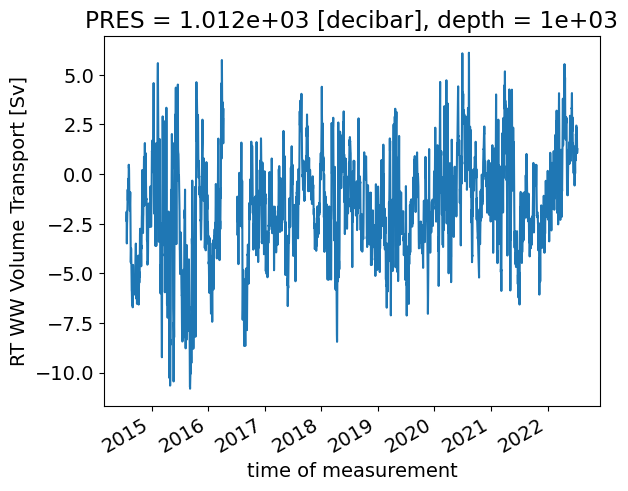

In [36]:
# Integrate for transport timeseries (Sv)
Q_WW = q_WW.sum(['depth','lon_WW'],min_count=1)/1e6 
Q_WW.coords['mask_WW'] = ds_RT.v_RTWB.isel(depth=50).notnull()
Q_WW.attrs['name']= 'RT_Q_WW'
Q_WW.attrs['long_name']= 'RT WW Volume Transport'
Q_WW.attrs['units']='Sv'
Q_WW.attrs['Description']='Volume transport at western wedge of Rockall Trough'\
' derived from moored velocity measurements at RTWB1+2'
Q_WW.where(Q_WW.mask_WW).plot()

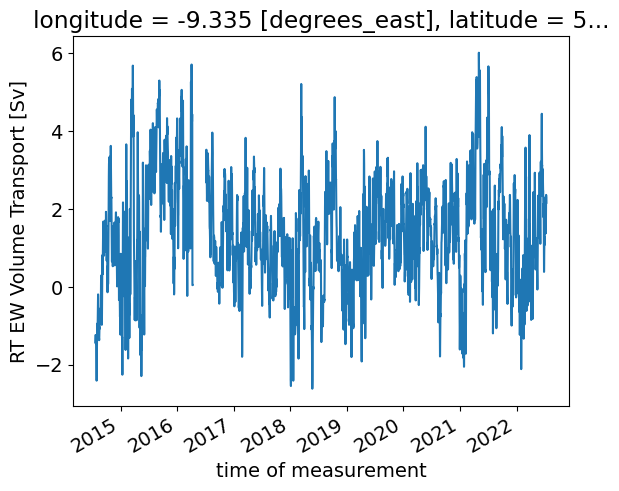

In [37]:
## Eastern wedge
v_GLO_RTADCP = ds_GLORYS.vo.interp(longitude=lon_RTADCP,
                    latitude=lat_RTADCP,
                    time=('TIME',ds_RT.TIME.data),
                    depth=('depth',ds_RT.depth.data)) + corr_model

# Duplicate top and bottom GLORYS-ADCP values
v_GLO_RTADCP = v_GLO_RTADCP.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")

# create velocity matrix with mooring velocity at western border
(v_EW,_) = xr.broadcast(ds_RT.V_EAST/100,xr.DataArray(lon_EW, dims="lon_EW"))
v_EW.coords['lon_EW'] = lon_EW
v_EW0 = v_EW.where((ds_RT.depth<z_cutoff_EW)).where(lon_EW==lon_EW[-1])*0
v_EW1 = v_EW.where((ds_RT.depth>z_cutoff_EW))
v_EW = v_EW.where((ds_RT.depth<z_cutoff_EW)).where(lon_EW<lon_EW[1])

# combine both
mask = (v_EW.notnull()+v_EW1.notnull()+v_EW0.notnull())
v_EW = (v_EW.fillna(0)+v_EW1.fillna(0)+v_EW0.fillna(0)).where(mask)


# create velocity matrix with GLORYS-ADCP closest to the position of RTADCP
(v_EW2,_) = xr.broadcast(v_GLO_RTADCP,xr.DataArray(lon_EW, dims="lon_EW"))
v_EW2.coords['lon_EW'] = lon_EW
v_EW2.coords['lat_EW'] = lat_EW
v_EW3 = v_EW2
v_EW2 = v_EW2.where((ds_RT.depth<z_cutoff_EW)
                   ).where(lon_EW==v_EW2.lon_EW.sel(lon_EW=lon_RTADCP,method='nearest').values)

# ############################ to be commented if matlab-style (not correct) is wanted - see below
# # Python version (correct version)
mask = (v_EW.notnull()+v_EW2.notnull())
v_EW = (v_EW.fillna(0)+v_EW2.fillna(0)).where(mask)

# ########################### matlab style - to be uncommented if original ouput is wanted (Fraser et al., 2022)
# # In the matlab script the GLORY ADCP data was duplicated to the lon east of the ADCP before interpolating to zero. This causes a deviation of ~0.01cm/s
# # To include the original matlab-style interpolation the following code need to replace the two lines above
# ###########################
# # v_EW3 = v_EW3.where((ds_RT.depth>z_cutoff_EW)
# #                    ).where(lon_EW==v_EW2.lon_EW.sel(lon_EW=-9.331,method='nearest').values)

# # # combine both
# # mask = (v_EW.notnull()+v_EW2.notnull()+v_EW3.notnull())
# # v_EW = (v_EW.fillna(0)+v_EW2.fillna(0)+v_EW3.fillna(0)).where(mask)
# ############################

# Linear interpolation from mooring velocity to GLORYS-ADCP in depth shallower than 750m 
v_EW = v_EW.interpolate_na(dim="lon_EW", method="linear")

# Mask bathy
v_EW = v_EW.where(v_EW.depth<-1*bathy_EW)

# Transport in each cell
q_EW = dx_EW*ds_RT.dz*(v_EW)

# Integrate for transport timeseries (Sv)
Q_EW = q_EW.sum(['depth','lon_EW'],min_count=1)/1e6
Q_EW.coords['mask_EW'] = ds_RT.V_WEST_1.isel(depth=50).notnull()
Q_EW.attrs['name']= 'RT_Q_EW'
Q_EW.attrs['long_name']= 'RT EW Volume Transport'
Q_EW.attrs['units']='Sv'
Q_EW.attrs['Description']='Volume transport at eastern wedge of Rockall Trough'\
' derived from moored velocity measurements at RTEB1'
Q_EW.where(Q_EW.mask_EW).plot()

In [38]:
ds_q_RTMB

<xarray.Dataset>
Dimensions:  (depth: 101, TIME: 5827, lon_MB: 99)
Coordinates:
    PRES     (depth) float64 0.0 20.19 40.38 60.57 ... 1.988e+03 nan nan
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * TIME     (TIME) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    lat_MB   (lon_MB) float64 57.47 57.46 57.46 57.46 ... 57.11 57.11 57.1 57.1
  * lon_MB   (lon_MB) float64 -12.49 -12.46 -12.43 ... -9.638 -9.609 -9.579
    dx       (lon_MB) float64 913.2 1.826e+03 1.827e+03 ... 1.843e+03 921.7
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (depth, lon_MB, TIME) float64 826.5 827.8 840.9 ... nan nan nan
    CT       (lon_MB, TIME, depth) float64 10.22 10.22 10.22 ... nan nan nan
    SA       (lon_MB, TIME, depth) float64 35.56 35.56 35.56 ... nan nan nan

### Ekman and co

In [31]:
# Ekman transport
ds_ERA_MB = ds_ERA5[['metss','mntss']].interp(longitude=ds_q_RTMB.lon_MB, latitude=ds_q_RTMB.lat_MB).drop(['longitude','latitude'])
ds_ERA_MB.coords['lon_MB']=ds_q_RTMB.lon_MB
ds_ERA_WW = ds_ERA5[['metss','mntss']].interp(longitude=lon_WW, latitude=lat_WW).drop(['longitude','latitude'])
ds_ERA_WW.coords['lon_WW']=lon_WW
ds_ERA_EW = ds_ERA5[['metss','mntss']].interp(longitude=lon_EW, latitude= lat_EW).drop(['longitude','latitude'])
ds_ERA_EW.coords['lon_EW']=lon_EW

# Get normal and tangent to each section
def tau_rot(ds,lat,lon):
    (_,pa) = np.radians(sw.dist(lat[:2],lon[:2],'km'))
    tau_rot = np.cos(pa)*ds.metss + np.sin(pa)*ds.mntss
    return tau_rot

# Get tau tangent to section
tau_para_MB = tau_rot(ds_ERA_MB,lat_MB,lon_MB)
tau_para_WW = tau_rot(ds_ERA_WW,lat_WW,lon_WW)
tau_para_EW = tau_rot(ds_ERA_EW,lat_EW,lon_EW)

# Get Ekman
f = 2*Omega*np.sin(np.radians(lat_RTWB))
V_Ek_WW = -1*tau_para_WW/(f*rho0)
V_Ek_MB = -1*tau_para_MB/(f*rho0)
V_Ek_EW = -1*tau_para_EW/(f*rho0)

# Transport per cell in Sv
q_Ek_WW = V_Ek_WW*dx_WW/1e6
q_Ek_MB = V_Ek_MB*dx_MB/1e6
q_Ek_EW = V_Ek_EW*dx_EW/1e6

# Integrate transport timeseries
Q_Ek_WW = q_Ek_WW.sum('lon_WW')
Q_Ek_WW.attrs['name']= 'Q_Ek_WW'
Q_Ek_WW.attrs['long_name']= 'RT WW Ekman Transport'
Q_Ek_WW.attrs['units']='Sv'
Q_Ek_WW.attrs['Description']= 'Ekman Transport at wester wedge of Rockall Trough'\
' derived from ERA5 monthly data'

Q_Ek_MB = q_Ek_MB.sum('lon_MB')
Q_Ek_MB.attrs['name']= 'Q_Ek_MB'
Q_Ek_MB.attrs['long_name']= 'RT MB Ekman Transport'
Q_Ek_MB.attrs['units']='Sv'
Q_Ek_MB.attrs['Description']= 'Ekman Transport across Rockall Trough'\
' derived from ERA5 monthly data'

Q_Ek_EW = q_Ek_EW.sum('lon_EW')
Q_Ek_EW.attrs['name']= 'Q_Ek_EW'
Q_Ek_EW.attrs['long_name']= 'RT EW Ekman Transport'
Q_Ek_EW.attrs['units']='Sv'
Q_Ek_EW.attrs['Description']= 'Ekman Transport at eastern wedge of Rockall Trough'\
' derived from ERA5 monthly data'

# Merge to dataset
RT_Q_Ek = xr.merge([Q_Ek_WW.rename(Q_Ek_WW.attrs['name']),
                Q_Ek_MB.rename(Q_Ek_MB.attrs['name']),
                Q_Ek_EW.rename(Q_Ek_EW.attrs['name'])])
RT_Q_Ek

AttributeError: 'Dataset' object has no attribute 'lon_MB'

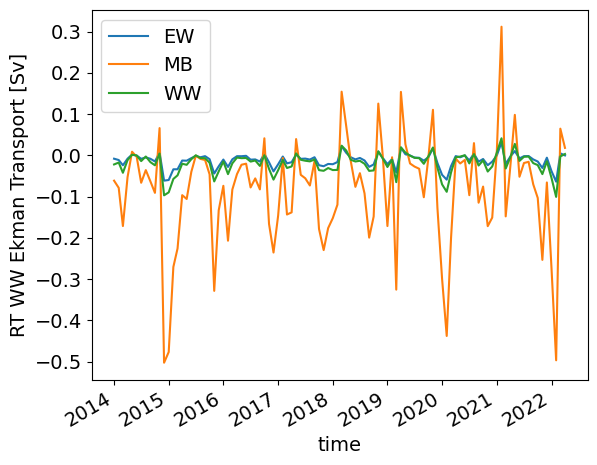

In [40]:
RT_Q_Ek.Q_Ek_EW.plot(label='EW')
RT_Q_Ek.Q_Ek_MB.plot(label='MB')
RT_Q_Ek.Q_Ek_WW.plot(label='WW')
plt.legend()

## Heat and Freshwater Fluxes

In [41]:
# Heat and Freshwater Fluxes

# Get SA and CT fields - interpolate for midbasin
ds_RT['SG_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2;
ds_RT['TG_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2;

# Compute fluxes in each cell
qh_EW = rhoCp*q_EW*(ds_RT.TG_EAST - CT_ref);
qh_MB = rhoCp*q_RTMB*(ds_q_RTMB.CT - CT_ref);
qh_WW = rhoCp*q_WW*(ds_RT.TG_WEST - CT_ref);
qf_EW = -1*q_EW*(ds_RT.SG_EAST - SA_ref)/SA_ref;
qf_MB = -1*q_RTMB*(ds_q_RTMB.SA - SA_ref)/SA_ref;
qf_WW = -1*q_WW*(ds_RT.SG_WEST - SA_ref)/SA_ref;
qS_EW = q_EW*ds_RT.SG_EAST/1027.4;
qS_MB = q_RTMB*ds_q_RTMB.SA/1027.4;
qS_WW = q_WW*ds_RT.SG_WEST/1027.4;

# % Integrate for timeseries (PW and Sv)
Qh_WW = qh_WW.sum(['depth','lon_WW'])/1e15;
Qh_MB = qh_MB.sum(['depth','lon_MB'])/1e15;
Qh_EW = qh_EW.sum(['depth','lon_EW'])/1e15;
Qf_WW = qf_WW.sum(['depth','lon_WW'])/1e6;
Qf_MB = qf_MB.sum(['depth','lon_MB'])/1e6;
Qf_EW = qf_EW.sum(['depth','lon_EW'])/1e6;
QS_WW = qS_WW.sum(['depth','lon_WW'])/1e3;
QS_MB = qS_MB.sum(['depth','lon_MB'])/1e3;
QS_EW = qS_EW.sum(['depth','lon_EW'])/1e3;

## set attributes
Qh_EW.coords['mask_EW'] = Q_EW.mask_EW
Qh_EW.attrs['name']= 'RT_Qh_EW'
Qh_EW.attrs['long_name']= 'RT EW Heat Flux'
Qh_EW.attrs['units']='PW'
Qh_EW.attrs['Description']='Heat flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'
Qh_WW.coords['mask_WW'] = Q_WW.mask_WW
Qh_WW.attrs['name']= 'RT_Qh_WW'
Qh_WW.attrs['long_name']= 'RT WW Heat Flux'
Qh_WW.attrs['units']='PW'
Qh_WW.attrs['Description']='Heat flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'
Qh_MB.attrs['name']= 'RT_Qh_MB'
Qh_MB.attrs['long_name']= 'RT MB Heat Flux'
Qh_MB.attrs['units']='PW'
Qh_MB.attrs['Description']='Mid basin heat flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'

Qf_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf_EW.attrs['name']= 'RT_Qf_EW'
Qf_EW.attrs['long_name']= 'RT EW Freshwater flux'
Qf_EW.attrs['units']='PW'
Qf_EW.attrs['Description']='Freshwater flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf_WW.attrs['name']= 'RT_Qf_WW'
Qf_WW.attrs['long_name']= 'RT WW Freshwater Flux'
Qf_WW.attrs['units']='PW'
Qf_WW.attrs['Description']='Freshwater flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf_MB.attrs['name']= 'RT_Qf_MB'
Qf_MB.attrs['long_name']= 'RT MB Freshwater Flux'
Qf_MB.attrs['units']='PW'
Qf_MB.attrs['Description']='Mid basin freshwater flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS_EW.coords['mask_EW'] = Q_EW.mask_EW
QS_EW.attrs['name']= 'RT_QS_EW'
QS_EW.attrs['long_name']= 'RT EW salt flux'
QS_EW.attrs['units']='PW'
QS_EW.attrs['Description']='salt flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS_WW.coords['mask_WW'] = Q_WW.mask_WW
QS_WW.attrs['name']= 'RT_QS_WW'
QS_WW.attrs['long_name']= 'RT WW salt Flux'
QS_WW.attrs['units']='PW'
QS_WW.attrs['Description']='salt flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS_MB.attrs['name']= 'RT_QS_MB'
QS_MB.attrs['long_name']= 'RT MB salt Flux'
QS_MB.attrs['units']='PW'
QS_MB.attrs['Description']='Mid basin salt flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [42]:
# upper 1000 EW, glider comparison
tlim_glider = ['2020-04-10','2020-08-06']
Qh_EW_1000 = qh_EW.sel(depth=slice(None,1000),TIME=slice(*tlim_glider)).sum(['depth','lon_EW'])/1e15;
Qf_EW_1000 = qf_EW.sel(depth=slice(None,1000),TIME=slice(*tlim_glider)).sum(['depth','lon_EW'])/1e6;

Qh_EW_1000.coords['mask_EW'] = Q_EW.mask_EW
Qh_EW_1000.attrs['name']= 'RT_Qh_EW_1000'
Qh_EW_1000.attrs['long_name']= 'RT EW Heat Flux for upper 1000m'
Qh_EW_1000.attrs['units']='PW'
Qh_EW_1000.attrs['Description']='Heat flux at eastern wedge of Rockall Trough for upper 1000m'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'

Qf_EW_1000.coords['mask_EW'] = Q_EW.mask_EW
Qf_EW_1000.attrs['name']= 'RT_Qf_EW_1000'
Qf_EW_1000.attrs['long_name']= 'RT EW Freshwater flux for upper 1000m'
Qf_EW_1000.attrs['units']='PW'
Qf_EW_1000.attrs['Description']='Freshwater flux at eastern wedge of Rockall Trough for upper 1000m'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

In [43]:
# isolate tracer vs vel part

# Compute fluxes in each cell
qh1_EW = rhoCp*q_EW*(ds_RT.TG_EAST.mean('TIME') - CT_ref);
qh1_MB = rhoCp*q_MB*(ds_RT.TG_MB.mean('TIME') - CT_ref);
qh1_WW = rhoCp*q_WW*(ds_RT.TG_WEST.mean('TIME') - CT_ref);
qf1_EW = -1*q_EW*(ds_RT.SG_EAST.mean('TIME') - SA_ref)/SA_ref;
qf1_MB = -1*q_MB*(ds_RT.SG_MB.mean('TIME') - SA_ref)/SA_ref;
qf1_WW = -1*q_WW*(ds_RT.SG_WEST.mean('TIME') - SA_ref)/SA_ref;
qS1_EW = q_EW*ds_RT.SG_EAST.mean('TIME')/1027.4;
qS1_MB = q_MB*ds_RT.SG_MB.mean('TIME')/1027.4;
qS1_WW = q_WW*ds_RT.SG_WEST.mean('TIME')/1027.4;

qh2_EW = rhoCp*q_EW.mean('TIME')*(ds_RT.TG_EAST - CT_ref);
qh2_MB = rhoCp*q_MB.mean('TIME')*(ds_RT.TG_MB - CT_ref);
qh2_WW = rhoCp*q_WW.mean('TIME')*(ds_RT.TG_WEST - CT_ref);
qf2_EW = -1*q_EW.mean('TIME')*(ds_RT.SG_EAST - SA_ref)/SA_ref;
qf2_MB = -1*q_MB.mean('TIME')*(ds_RT.SG_MB - SA_ref)/SA_ref;
qf2_WW = -1*q_WW.mean('TIME')*(ds_RT.SG_WEST - SA_ref)/SA_ref;
qS2_EW = q_EW.mean('TIME')*ds_RT.SG_EAST/1027.4;
qS2_MB = q_MB.mean('TIME')*ds_RT.SG_MB/1027.4;
qS2_WW = q_WW.mean('TIME')*ds_RT.SG_WEST/1027.4;

# % Integrate for timeseries (PW and Sv)
Qh1_WW = qh1_WW.sum(['depth','lon_WW'])/1e15;
Qh1_MB = qh1_MB.sum('depth')/1e15;
Qh1_EW = qh1_EW.sum(['depth','lon_EW'])/1e15;
Qf1_WW = qf1_WW.sum(['depth','lon_WW'])/1e6;
Qf1_MB = qf1_MB.sum('depth')/1e6;
Qf1_EW = qf1_EW.sum(['depth','lon_EW'])/1e6;
QS1_WW = qS1_WW.sum(['depth','lon_WW'])/1e3;
QS1_MB = qS1_MB.sum('depth')/1e3;
QS1_EW = qS1_EW.sum(['depth','lon_EW'])/1e3;

Qh2_WW = qh2_WW.sum(['depth','lon_WW'])/1e15;
Qh2_MB = qh2_MB.sum('depth')/1e15;
Qh2_EW = qh2_EW.sum(['depth','lon_EW'])/1e15;
Qf2_WW = qf2_WW.sum(['depth','lon_WW'])/1e6;
Qf2_MB = qf2_MB.sum('depth')/1e6;
Qf2_EW = qf2_EW.sum(['depth','lon_EW'])/1e6;
QS2_WW = qS2_WW.sum(['depth','lon_WW'])/1e3;
QS2_MB = qS2_MB.sum('depth')/1e3;
QS2_EW = qS2_EW.sum(['depth','lon_EW'])/1e3;

Qh1_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf1_EW.coords['mask_EW'] = Q_EW.mask_EW
QS1_EW.coords['mask_EW'] = Q_EW.mask_EW
Qh2_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf2_EW.coords['mask_EW'] = Q_EW.mask_EW
QS2_EW.coords['mask_EW'] = Q_EW.mask_EW

Qh1_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf1_WW.coords['mask_WW'] = Q_WW.mask_WW
QS1_WW.coords['mask_WW'] = Q_WW.mask_WW
Qh2_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf2_WW.coords['mask_WW'] = Q_WW.mask_WW
QS2_WW.coords['mask_WW'] = Q_WW.mask_WW

In [44]:
Qh1_EW.attrs['name']= 'RT_Qh_EW_Tfix'
Qh1_EW.attrs['long_name']= 'RT EW Heat Flux Tfix'
Qh1_EW.attrs['units']='PW'
Qh1_EW.attrs['Description']='Heat flux at eastern wedge of Rockall Trough using temporal mean temperature profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'
Qh1_WW.attrs['name']= 'RT_Qh_WW_Tfix'
Qh1_WW.attrs['long_name']= 'RT WW Heat Flux Tfix'
Qh1_WW.attrs['units']='PW'
Qh1_WW.attrs['Description']='Heat flux at western wedge of Rockall Trough using temporal mean temperature profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'
Qh1_MB.attrs['name']= 'RT_Qh_MB_Tfix'
Qh1_MB.attrs['long_name']= 'RT MB Heat Flux Tfix'
Qh1_MB.attrs['units']='PW'
Qh1_MB.attrs['Description']='Mid basin heat flux in Rockall Trough using temporal mean temperature profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'

Qf1_EW.attrs['name']= 'RT_Qf_EW_Sfix'
Qf1_EW.attrs['long_name']= 'RT EW Freshwater flux_Sfix'
Qf1_EW.attrs['units']='PW'
Qf1_EW.attrs['Description']='Freshwater flux at eastern wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf1_WW.attrs['name']= 'RT_Qf_WW_Sfix'
Qf1_WW.attrs['long_name']= 'RT WW Freshwater Flux_Sfix'
Qf1_WW.attrs['units']='PW'
Qf1_WW.attrs['Description']='Freshwater flux at western wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf1_MB.attrs['name']= 'RT_Qf_MB_Sfix'
Qf1_MB.attrs['long_name']= 'RT MB Freshwater Flux_Sfix'
Qf1_MB.attrs['units']='PW'
Qf1_MB.attrs['Description']='Mid basin freshwater flux in Rockall Trough using temporal mean salinity profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS1_EW.attrs['name']= 'RT_QS_EW_Sfix'
QS1_EW.attrs['long_name']= 'RT EW salt flux_Sfix'
QS1_EW.attrs['units']='PW'
QS1_EW.attrs['Description']='salt flux at eastern wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS1_WW.attrs['name']= 'RT_QS_WW_Sfix'
QS1_WW.attrs['long_name']= 'RT WW salt Flux_Sfix'
QS1_WW.attrs['units']='PW'
QS1_WW.attrs['Description']='salt flux at western wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS1_MB.attrs['name']= 'RT_QS_MB_Sfix'
QS1_MB.attrs['long_name']= 'RT MB salt Flux_Sfix'
QS1_MB.attrs['units']='PW'
QS1_MB.attrs['Description']='Mid basin salt flux in Rockall Trough using temporal mean salinity profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [45]:
Qh2_EW.attrs['name']= 'RT_Qh_EW_qfix'
Qh2_EW.attrs['long_name']= 'RT EW Heat Flux qfix'
Qh2_EW.attrs['units']='PW'
Qh2_EW.attrs['Description']='Heat flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'
Qh2_WW.attrs['name']= 'RT_Qh_WW_qfix'
Qh2_WW.attrs['long_name']= 'RT WW Heat Flux qfix'
Qh2_WW.attrs['units']='PW'
Qh2_WW.attrs['Description']='Heat flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'
Qh2_MB.attrs['name']= 'RT_Qh_MB_qfix'
Qh2_MB.attrs['long_name']= 'RT MB Heat Flux qfix'
Qh2_MB.attrs['units']='PW'
Qh2_MB.attrs['Description']='Mid basin heat flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'

Qf2_EW.attrs['name']= 'RT_Qf_EW_qfix'
Qf2_EW.attrs['long_name']= 'RT EW Freshwater flux_qfix'
Qf2_EW.attrs['units']='PW'
Qf2_EW.attrs['Description']='Freshwater flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf2_WW.attrs['name']= 'RT_Qf_WW_qfix'
Qf2_WW.attrs['long_name']= 'RT WW Freshwater Flux_qfix'
Qf2_WW.attrs['units']='PW'
Qf2_WW.attrs['Description']='Freshwater flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf2_MB.attrs['name']= 'RT_Qf_MB_qfix'
Qf2_MB.attrs['long_name']= 'RT MB Freshwater Flux_qfix'
Qf2_MB.attrs['units']='PW'
Qf2_MB.attrs['Description']='Mid basin freshwater flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS2_EW.attrs['name']= 'RT_QS_EW_qfix'
QS2_EW.attrs['long_name']= 'RT EW salt flux_qfix'
QS2_EW.attrs['units']='PW'
QS2_EW.attrs['Description']='salt flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS2_WW.attrs['name']= 'RT_QS_WW_qfix'
QS2_WW.attrs['long_name']= 'RT WW salt Flux_qfix'
QS2_WW.attrs['units']='PW'
QS2_WW.attrs['Description']='salt flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS2_MB.attrs['name']= 'RT_QS_MB_qfix'
QS2_MB.attrs['long_name']= 'RT MB salt Flux_qfix'
QS2_MB.attrs['units']='PW'
QS2_MB.attrs['Description']='Mid basin salt flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [46]:
#low pass filter
dt = 0.5 # twice per day, time step of sampling
fs = 1/dt # sample rate (1/day)
lowcut = 1/filter_length # cut off frequency
with xr.set_options(keep_attrs=True):
    Q_MB_lp = lazy_butter_lp_filter(Q_MB,lowcut,fs,dim='TIME')
    # Transports
    Q_MB_lp = lazy_butter_lp_filter(Q_MB,lowcut,fs,dim='TIME')
    Q_MB_SAfix = lazy_butter_lp_filter(Q_MB_SAfix,lowcut,fs,dim='TIME')
    Q_MB_CTfix = lazy_butter_lp_filter(Q_MB_CTfix,lowcut,fs,dim='TIME')
    Q_MB_SAfix_CTfix = lazy_butter_lp_filter(Q_MB_SAfix_CTfix,lowcut,fs,dim='TIME')
    Q_MB_WB_CTvar = lazy_butter_lp_filter(Q_MB_WB_CTvar,lowcut,fs,dim='TIME')
    Q_MB_EB_CTvar = lazy_butter_lp_filter(Q_MB_EB_CTvar,lowcut,fs,dim='TIME')
    Q_WW_lp = lazy_butter_lp_filter(Q_WW.fillna(0),lowcut,fs,dim='TIME')
    Q_WW_lp = Q_WW_lp.where(Q_WW.notnull())
    Q_EW_lp = lazy_butter_lp_filter(Q_EW.fillna(0),lowcut,fs,dim='TIME')
    Q_EW_lp = Q_EW_lp.where(Q_EW.notnull())

    # Heat flux
    Qh_MB_lp = lazy_butter_lp_filter(Qh_MB,lowcut,fs,dim='TIME')
    Qh_WW_lp = lazy_butter_lp_filter(Qh_WW,lowcut,fs,dim='TIME')
    Qh_EW_lp = lazy_butter_lp_filter(Qh_EW,lowcut,fs,dim='TIME')
    Qh1_MB_lp = lazy_butter_lp_filter(Qh1_MB,lowcut,fs,dim='TIME')
    Qh1_WW_lp = lazy_butter_lp_filter(Qh1_WW,lowcut,fs,dim='TIME')
    Qh1_EW_lp = lazy_butter_lp_filter(Qh1_EW,lowcut,fs,dim='TIME')
    Qh2_MB_lp = lazy_butter_lp_filter(Qh2_MB,lowcut,fs,dim='TIME')
    Qh2_WW_lp = lazy_butter_lp_filter(Qh2_WW,lowcut,fs,dim='TIME')
    Qh2_EW_lp = lazy_butter_lp_filter(Qh2_EW,lowcut,fs,dim='TIME')

    # Freshwater flux
    Qf_MB_lp = lazy_butter_lp_filter(Qf_MB,lowcut,fs,dim='TIME')
    Qf_WW_lp = lazy_butter_lp_filter(Qf_WW,lowcut,fs,dim='TIME')
    Qf_EW_lp = lazy_butter_lp_filter(Qf_EW,lowcut,fs,dim='TIME')
    Qf1_MB_lp = lazy_butter_lp_filter(Qf1_MB,lowcut,fs,dim='TIME')
    Qf1_WW_lp = lazy_butter_lp_filter(Qf1_WW,lowcut,fs,dim='TIME')
    Qf1_EW_lp = lazy_butter_lp_filter(Qf1_EW,lowcut,fs,dim='TIME')
    Qf2_MB_lp = lazy_butter_lp_filter(Qf2_MB,lowcut,fs,dim='TIME')
    Qf2_WW_lp = lazy_butter_lp_filter(Qf2_WW,lowcut,fs,dim='TIME')
    Qf2_EW_lp = lazy_butter_lp_filter(Qf2_EW,lowcut,fs,dim='TIME')
    
    # Salt flux
    QS_MB_lp = lazy_butter_lp_filter(QS_MB,lowcut,fs,dim='TIME')
    QS_WW_lp = lazy_butter_lp_filter(QS_WW,lowcut,fs,dim='TIME')
    QS_EW_lp = lazy_butter_lp_filter(QS_EW,lowcut,fs,dim='TIME')
    QS1_MB_lp = lazy_butter_lp_filter(QS1_MB,lowcut,fs,dim='TIME')
    QS1_WW_lp = lazy_butter_lp_filter(QS1_WW,lowcut,fs,dim='TIME')
    QS1_EW_lp = lazy_butter_lp_filter(QS1_EW,lowcut,fs,dim='TIME')
    QS2_MB_lp = lazy_butter_lp_filter(QS2_MB,lowcut,fs,dim='TIME')
    QS2_WW_lp = lazy_butter_lp_filter(QS2_WW,lowcut,fs,dim='TIME')
    QS2_EW_lp = lazy_butter_lp_filter(QS2_EW,lowcut,fs,dim='TIME')

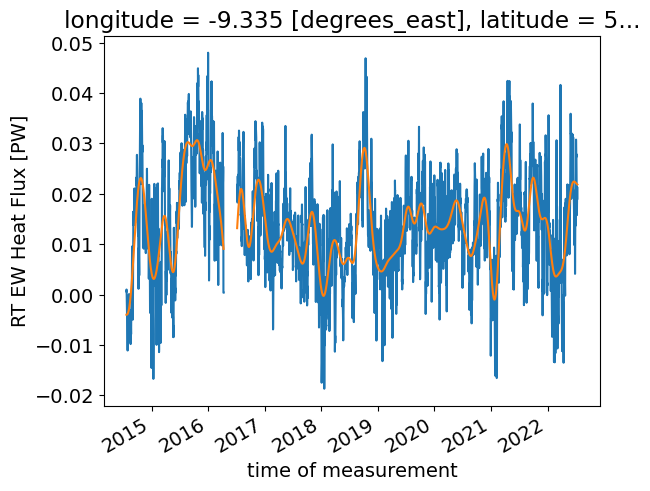

In [47]:
Qh_EW.where(Qh_EW.mask_EW).plot()
Qh_EW_lp.where(Qh_EW.mask_EW).plot()

In [48]:
# Get depth-accumulated transport
qz_EW = q_EW.sum('lon_EW')
qz_WW = q_WW.sum('lon_WW')
qz_MB = q_RTMB.sum('lon_MB')
Q_MB_cumul = qz_MB.sel(depth=slice(None,P_ref))/1e6
Q_EW_cumul = qz_EW.sel(depth=slice(None,P_ref))/1e6
Q_WW_cumul = qz_WW.sel(depth=slice(None,P_ref))/1e6

In [49]:
# transport
SEw = std_error(Q_WW)
SEm = std_error(Q_MB)
SEe = std_error(Q_EW)
SE = std_error((Q_WW.fillna(0) + Q_MB + Q_EW.fillna(0)))

# # HF
SEhw = std_error(Qh_WW)
SEhm = std_error(Qh_MB)
SEhe = std_error(Qh_EW)
SEh = std_error((Qh_WW.fillna(0) + Qh_MB + Qh_EW.fillna(0)))

# # FF
SEfw = std_error(Qf_WW)
SEfm = std_error(Qf_MB)
SEfe = std_error(Qf_EW)
SEf = std_error((Qf_WW.fillna(0) + Qf_MB + Qf_EW.fillna(0)))

'x has 5827 data cycles'

'Integral time scale (days) = 67.47983775778272'

' : Degrees of freedom = 86.35171917448703'

'x has 5827 data cycles'

'Integral time scale (days) = 137.82895306656604'

' : Degrees of freedom = 42.27703882496869'

'x has 5827 data cycles'

'Integral time scale (days) = 68.51721584758108'

' : Degrees of freedom = 85.04431956141305'

'x has 5827 data cycles'

'Integral time scale (days) = 113.71801019765019'

' : Degrees of freedom = 51.24078402244508'

'x has 5827 data cycles'

'Integral time scale (days) = 59.91585129632259'

' : Degrees of freedom = 97.25306198491148'

'x has 5827 data cycles'

'Integral time scale (days) = 136.16642420096852'

' : Degrees of freedom = 42.79322185474967'

'x has 5827 data cycles'

'Integral time scale (days) = 77.06284880528995'

' : Degrees of freedom = 75.61360746892097'

'x has 5827 data cycles'

'Integral time scale (days) = 102.36659951773646'

' : Degrees of freedom = 56.92286378029379'

'x has 5827 data cycles'

'Integral time scale (days) = 64.63020816061047'

' : Degrees of freedom = 90.1590783294324'

'x has 5827 data cycles'

'Integral time scale (days) = 394.65489345023013'

' : Degrees of freedom = 14.764798553637704'

'x has 5827 data cycles'

'Integral time scale (days) = 139.98386479627527'

' : Degrees of freedom = 41.62622605455487'

'x has 5827 data cycles'

'Integral time scale (days) = 290.4009529285547'

' : Degrees of freedom = 20.0653611540785'

In [50]:
print(SE.values)
print(SEh.values)
print(SEf.values)

0.47005160697445936
0.0033602756995855577
0.002524792934220705


In [51]:
Q_total = Q_WW.fillna(0)+Q_EW.fillna(0)+Q_MB
Q_total_lp = Q_WW_lp.fillna(0) + Q_MB_lp + Q_EW_lp.fillna(0)

Qh_total = Qh_WW.fillna(0)+Qh_EW.fillna(0)+Qh_MB
Qh_total_lp = Qh_WW_lp.fillna(0) + Qh_MB_lp + Qh_EW_lp.fillna(0)

Qf_total = Qf_WW.fillna(0)+Qf_EW.fillna(0)+Qf_MB
Qf_total_lp = Qf_WW_lp.fillna(0) + Qf_MB_lp + Qf_EW_lp.fillna(0)


Q_total.coords['mask']=(Q_total.mask_EW+Q_total.mask_WW)
Q_total = Q_total.where(Q_total.mask).compute()
Q_total_lp = Q_total_lp.where(Q_total.mask).compute()

Qh_total = Qh_total.where(Q_total.mask).compute()
Qh_total_lp = Qh_total_lp.where(Q_total.mask).compute()

Qf_total = Qf_total.where(Q_total.mask).compute()
Qf_total_lp = Qf_total_lp.where(Q_total.mask).compute()

In [52]:
SE_pre_2017 = std_error(Q_total.sel(TIME=slice(None,'2017')))
SEh_pre_2017 = std_error(Qh_total.sel(TIME=slice(None,'2017')))
SEf_pre_2017 = std_error(Qf_total.sel(TIME=slice(None,'2017')))

SE_after_2017 = std_error(Q_total.sel(TIME=slice('2017',None)))
SEh_after_2017 = std_error(Qh_total.sel(TIME=slice('2017',None)))
SEf_after_2017 = std_error(Qf_total.sel(TIME=slice('2017',None)))

Q=Q_total.sel(TIME=slice(None,'2017'))
print(f"Q Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SE_pre_2017.values}")
Q=Qh_total.sel(TIME=slice(None,'2017'))
print(f"Qh Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEh_pre_2017.values}")
Q=Qf_total.sel(TIME=slice(None,'2017'))
print(f"Qf Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEf_pre_2017.values}")


'x has 2519 data cycles'

'Integral time scale (days) = 64.68255646920272'

' : Degrees of freedom = 38.94403897284688'

'x has 2519 data cycles'

'Integral time scale (days) = 108.26149541046635'

' : Degrees of freedom = 23.26773697748564'

'x has 2519 data cycles'

'Integral time scale (days) = 267.93574995921654'

' : Degrees of freedom = 9.401507638989669'

'x has 4038 data cycles'

'Integral time scale (days) = 130.60866945774958'

' : Degrees of freedom = 30.9167838303892'

'x has 4038 data cycles'

'Integral time scale (days) = 123.53939996981916'

' : Degrees of freedom = 32.685928545763446'

'x has 4038 data cycles'

'Integral time scale (days) = 147.44355443436035'

' : Degrees of freedom = 27.38675159786423'

Q Pre 2017 mean is 4.587932838787957, std dev is 3.4965380329132527, std error is 0.5602963082878667
Qh Pre 2017 mean is 0.0514804644787142, std dev is 0.026664663026967683, std error is 0.005527885346372154
Qf Pre 2017 mean is -0.023079507317524877, std dev is 0.013080525596472289, std error is 0.004266054932006767


In [53]:
Q=Q_total.sel(TIME=slice('2017',None))
print(f"Q after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SE_pre_2017.values}")
Q=Qh_total.sel(TIME=slice('2017',None))
print(f"Qh after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEh_pre_2017.values}")
Q=Qf_total.sel(TIME=slice('2017',None))
print(f"Qf after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEf_pre_2017.values}")

Q after 2017 mean is 4.244038202690384, std dev is 3.380201726436018, std error is 0.5602963082878667
Qh after 2017 mean is 0.04424928101169509, std dev is 0.024911524796796317, std error is 0.005527885346372154
Qf after 2017 mean is -0.01704333053563411, std dev is 0.009602340643774519, std error is 0.004266054932006767


In [54]:
units = 'Sv'
name = 'Volume\n Transport'
Q_total.attrs = dict(long_name=name, units=units)
Q_total_lp.attrs = dict(long_name=name, units=units)

units = 'PW'
name = 'Heat\n Transport'
Qh_total.attrs = dict(long_name=name, units=units)
Qh_total_lp.attrs = dict(long_name=name, units=units)

units ='Sv'
name = 'Freshwater\n Transport'
Qf_total.attrs = dict(long_name=name, units=units)
Qf_total_lp.attrs = dict(long_name=name, units=units)

In [55]:
dim = 'TIME'
fit, slope, intc, trend_significant = detrend_data(Q_total,dim)

'x has 5827 data cycles'

'Integral time scale (days) = 103.81490563708019'

' : Degrees of freedom = 56.1287414773581'

In [56]:
# prepare data to save
SE.attrs = {'name':'SE_total',
            'long_name':'Standard error',
            'description':'Standard error of total volume flux Q_total, Rockall Trough',
             'units':'Sv'}
SEe.attrs = {'name':'SE_EW',
            'long_name':'Standard error',
            'description':'Standard error of volume flux Q_EW at eastern wedge of Rockall Trough',
             'units':'Sv'}
SEm.attrs = {'name':'SE_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin volume flux Q_MB of Rockall Trough',
             'units':'Sv'}
SEw.attrs = {'name':'SE_WE',
            'long_name':'Standard error',
            'description':'Standard error of volume flux Q_WW at western wedge of Rockall Trough',
             'units':'Sv'}

SEh.attrs = {'name':'SEh_total',
            'long_name':'Standard error',
            'description':'Standard error of total heat flux Qh_total, Rockall Trough',
             'units':'PW'}
SEhe.attrs = {'name':'SEh_EW',
            'long_name':'Standard error',
            'description':'Standard error of heat flux Qh_EW at eastern wedge of Rockall Trough',
             'units':'PW'}
SEhm.attrs = {'name':'SEh_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin heat flux Qh_MB of Rockall Trough',
             'units':'PW'}
SEhw.attrs = {'name':'SEh_WE',
            'long_name':'Standard error',
            'description':'Standard error of heat flux Qh_WW at western wedge of Rockall Trough',
             'units':'PW'}

SEf.attrs = {'name':'SEf_total',
            'long_name':'Standard error',
            'description':'Standard error of total freshwater flux Qf_total, Rockall Trough',
             'units':'Sv'}
SEfe.attrs = {'name':'SEf_EW',
            'long_name':'Standard error',
            'description':'Standard error of freshwater flux Qf_EW at eastern wedge of Rockall Trough',
             'units':'Sv'}
SEfm.attrs = {'name':'SEf_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin freshwater flux Qf_MB of Rockall Trough',
             'units':'Sv'}
SEfw.attrs = {'name':'SEf_WE',
            'long_name':'Standard error',
            'description':'Standard error of freshwater flux Qf_WW at western wedge of Rockall Trough',
             'units':'Sv'}


In [57]:
RT_Q_Qh_Qf = xr.merge([Q_total.rename('Q_total'),Q_total_lp.rename('Q_total_lp'),SE.rename('SE_total'),
          Q_EW.rename('Q_EW'),Q_EW_lp.rename('Q_EW_lp'),SEe.rename('SE_EW'),
          Q_MB.rename('Q_MB'),Q_MB_lp.rename('Q_MB_lp'),SEm.rename('SE_MB'),
          Q_WW.rename('Q_WW'),Q_WW_lp.rename('Q_WW_lp'),SEw.rename('SE_WW'),
          Qh_total.rename('Qh_total'),Qh_total_lp.rename('Qh_total_lp'),SEh.rename('SEh_total'),
          Qh_EW.rename('Qh_EW'),Qh_EW_lp.rename('Qh_EW_lp'),SEhe.rename('SEh_EW'),
          Qh_MB.rename('Qh_MB'),Qh_MB_lp.rename('Qh_MB_lp'),SEhm.rename('SEh_MB'),
          Qh_WW.rename('Qh_WW'),Qh_WW_lp.rename('Qh_WW_lp'),SEhw.rename('SEh_WW'),
          Qf_total.rename('Qf_total'),Qf_total_lp.rename('Qf_total_lp'),SEf.rename('SEf_total'),
          Qf_EW.rename('Qf_EW'),Qf_EW_lp.rename('Qf_EW_lp'),SEfe.rename('SEf_EW'),
          Qf_MB.rename('Qf_MB'),Qf_MB_lp.rename('Qf_MB_lp'),SEfm.rename('SEf_MB'),
          Qf_WW.rename('Qf_WW'),Qf_WW_lp.rename('Qf_WW_lp'),SEfw.rename('SEf_WW'),
         ])
RT_q = xr.merge([q_EW.rename('q_EW').drop(['longitude','latitude','time']),q_MB.rename('q_MB'),q_WW.rename('q_WW')])

In [58]:
ds_q_RTMB = ds_q_RTMB.drop('PRES').rename({'TIME':'time'})
ds_q_RTMB = ds_q_RTMB.rename({'lon_MB':'lon','lat_MB':'lat'})
ds_q_RTMB

<xarray.Dataset>
Dimensions:  (depth: 101, time: 5827, lon: 99)
Coordinates:
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    lat      (lon) float64 57.47 57.46 57.46 57.46 ... 57.11 57.11 57.1 57.1
  * lon      (lon) float64 -12.49 -12.46 -12.43 -12.4 ... -9.638 -9.609 -9.579
    dx       (lon) float64 913.2 1.826e+03 1.827e+03 ... 1.843e+03 921.7
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (depth, lon, time) float64 826.5 827.8 840.9 848.6 ... nan nan nan
    CT       (lon, time, depth) float64 10.22 10.22 10.22 10.22 ... nan nan nan
    SA       (lon, time, depth) float64 35.56 35.56 35.56 35.56 ... nan nan nan

In [59]:
ds_q_RTEW = xr.Dataset()
ds_q_RTEW['q']=(RT_q.reset_coords().q_EW.rename('q')).rename({'lon_EW':'lon'})
ds_q_RTEW.coords['lat']=RT_q.reset_coords().lat_EW.rename({'lon_EW':'lon'})
ds_q_RTEW.coords['dx']=dx_EW.rename({'lon_EW':'lon'})
ds_q_RTEW.coords['dz']=ds_q_RTMB.dz
mask = ds_q_RTEW.q.notnull()
ds_q_RTEW['CT'] = (ds_RT.TG_EAST*ds_q_RTEW.q.notnull()).where(mask)
ds_q_RTEW['SA'] = (ds_RT.SG_EAST*ds_q_RTEW.q.notnull()).where(mask)
ds_q_RTEW = ds_q_RTEW.drop('PRES').rename({'TIME':'time'})
ds_q_RTEW

<xarray.Dataset>
Dimensions:  (depth: 101, lon: 100, time: 5827)
Coordinates:
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * lon      (lon) float64 -9.564 -9.56 -9.557 -9.553 ... -9.2 -9.197 -9.193
  * time     (time) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    lat      (lon) float64 57.1 57.1 57.1 57.1 57.1 ... 57.1 57.1 57.1 57.1 57.1
    dx       (lon) float64 113.2 226.5 226.5 226.5 ... 226.5 226.5 226.5 113.2
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (lon, depth, time) float64 dask.array<chunksize=(100, 101, 5827), meta=np.ndarray>
    CT       (time, depth, lon) float64 dask.array<chunksize=(5827, 101, 100), meta=np.ndarray>
    SA       (time, depth, lon) float64 dask.array<chunksize=(5827, 101, 100), meta=np.ndarray>

In [60]:
ds_q_RTWW = xr.Dataset()
ds_q_RTWW['q']=(RT_q.reset_coords().q_WW.rename('q')).rename({'lon_WW':'lon'})
ds_q_RTWW.coords['lat']=RT_q.reset_coords().lat_WW.rename({'lon_WW':'lon'})
ds_q_RTWW.coords['dx']=dx_WW.rename({'lon_WW':'lon'})
ds_q_RTWW.coords['dz']=ds_q_RTMB.dz
mask = ds_q_RTWW.q.notnull()
ds_q_RTWW['CT'] = (ds_RT.TG_EAST*ds_q_RTWW.q.notnull()).where(mask)
ds_q_RTWW['SA'] = (ds_RT.SG_EAST*ds_q_RTWW.q.notnull()).where(mask)
ds_q_RTWW = ds_q_RTWW.drop('PRES').rename({'TIME':'time'})
ds_q_RTWW

<xarray.Dataset>
Dimensions:  (depth: 101, time: 5827, lon: 100)
Coordinates:
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
  * lon      (lon) float64 -13.03 -13.03 -13.02 -13.02 ... -12.52 -12.51 -12.51
    lat      (lon) float64 57.47 57.47 57.47 57.47 ... 57.47 57.47 57.47 57.47
    dx       (lon) float64 158.3 316.6 316.6 316.6 ... 316.6 316.6 316.6 158.3
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (lon, depth, time) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    CT       (time, depth, lon) float64 10.34 10.34 10.34 10.34 ... nan nan nan
    SA       (time, depth, lon) float64 35.58 35.58 35.58 35.58 ... nan nan nan

In [61]:
RT_q['dx_EW']=dx_EW
RT_q['dx_WW']=dx_WW
# RT_q['dx_MB']=dx_MB
RT_q['dz']=ds_RT.dz
 
RT_q['SA_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2;
RT_q['CT_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2;

mask = RT_q.q_EW.notnull()
RT_q['CT_EW'] = (ds_RT.TG_EAST*RT_q.q_EW.notnull()).where(mask)
RT_q['SA_EW'] = (ds_RT.SG_EAST*RT_q.q_EW.notnull()).where(mask)

mask = RT_q.q_WW.notnull()
RT_q['CT_WW'] = (ds_RT.TG_WEST*RT_q.q_WW.notnull()).where(mask)
RT_q['SA_WW'] = (ds_RT.SG_WEST*RT_q.q_WW.notnull()).where(mask)

In [62]:
RT_Q_Qh_Qf.to_netcdf(f'{data_out_path}RT_Q_Qh_Qf_timeseries_2014_2022.nc')
RT_q.to_netcdf(f'{data_out_path}RT_q_timeseries_2014_2022.nc')
RT_Q_Ek.to_netcdf(f'{data_out_path}RT_Ekman_timeseries_2014_2022.nc')

In [63]:
ds_q_RTMB.to_netcdf(f'{data_out_path}q_RTMB_timeseries_2014_2022.nc')
ds_q_RTWW.to_netcdf(f'{data_out_path}q_RTWW_timeseries_2014_2022.nc')
ds_q_RTEW.to_netcdf(f'{data_out_path}q_RTW_timeseries_2014_2022.nc')

# Plot timeseries

In [23]:
RT_Q_Qh_Qf = xr.open_dataset(f'{data_out_path}RT_Q_Qh_Qf_timeseries_2014_2022.nc')
RT_q = xr.open_dataset(f'{data_out_path}RT_q_timeseries_2014_2022.nc')
RT_Q_Ek = xr.open_dataset(f'{data_out_path}RT_Ekman_timeseries_2014_2022.nc')

In [24]:
ds_q_RTMB = xr.open_dataset(f'{data_out_path}q_RTMB_timeseries_2014_2022.nc')
ds_q_RTWW = xr.open_dataset(f'{data_out_path}q_RTWW_timeseries_2014_2022.nc')
ds_q_RTEW = xr.open_dataset(f'{data_out_path}q_RTW_timeseries_2014_2022.nc')

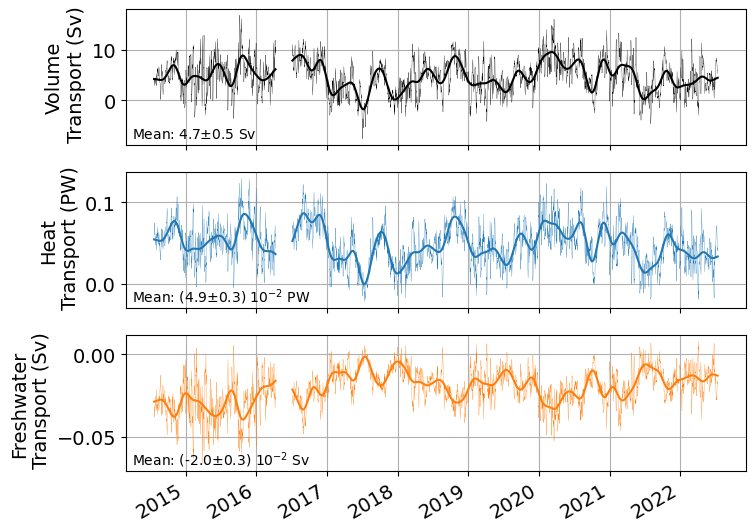

In [25]:
fig,axs = plt.subplots(3,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

# print(SE.values)
# print(SEh.values)
# print(SEf.values)

RT_Q_Qh_Qf.Q_total.where(RT_Q_Qh_Qf.mask_EW).plot.line('k',ax=axs[0],linewidth=.2)
RT_Q_Qh_Qf.Q_total_lp.where(RT_Q_Qh_Qf.mask_EW).plot.line('k',ax=axs[0],)
axs[0].text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_total.mean().values,RT_Q_Qh_Qf.SE_total.values)),
        fontsize=10,
        transform=axs[0].transAxes)

RT_Q_Qh_Qf.Qh_total.where(RT_Q_Qh_Qf.mask_EW).plot.line('C0',ax=axs[1],linewidth=.2)
RT_Q_Qh_Qf.Qh_total_lp.where(RT_Q_Qh_Qf.mask_EW).plot.line('C0',ax=axs[1],)
axs[1].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_total.mean().values*1e2,RT_Q_Qh_Qf.SEh_total.values*1e2)),
        fontsize=10,
        transform=axs[1].transAxes)

RT_Q_Qh_Qf.Qf_total.where(RT_Q_Qh_Qf.mask_EW).plot.line('C1',ax=axs[2],linewidth=.2)
RT_Q_Qh_Qf.Qf_total_lp.where(RT_Q_Qh_Qf.mask_EW).plot.line('C1',ax=axs[2],)
axs[2].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_total.mean().values*1e2,RT_Q_Qh_Qf.SEf_total.values*1e2)),
        fontsize=10,
        transform=axs[2].transAxes)

for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[i])
    ax.set_xlabel('')

# fig.savefig(r'C:\Users\sa07kb\Documents\Talks\20230423_28_EGU\Rockall_Trough_transports_2014_2022.png',dpi=300,bbox_inches='tight',)